In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Path style access for pandas
!pip install pandas-path
from pandas_path import path

import rasterio

import warnings
warnings.filterwarnings("ignore")

In [2]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent / "runtime" / "data" / "train_features"

In [3]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [4]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [5]:
train_metadata.shape

(1084, 6)

In [6]:
train_metadata.chip_id.nunique()

542

We have 542 unique chip id, every id has two images _vh and _vv

In [7]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [8]:
train_metadata

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
...,...,...,...,...,...,...,...,...
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1082,wvy31_vh,wvy31,wvy,vh,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...


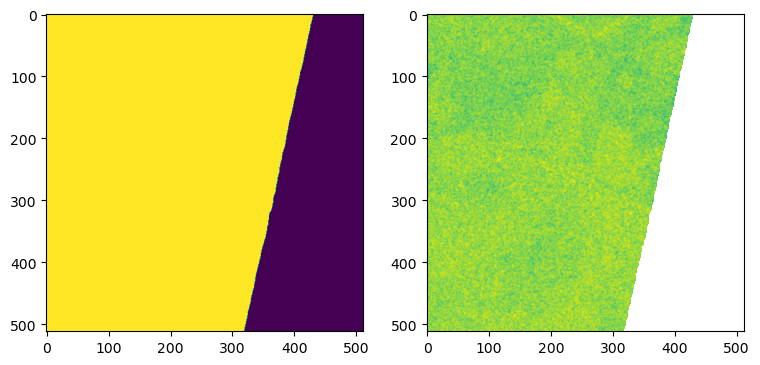

In [9]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band
    
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()
    
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)
    
f, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].imshow(gdal_mask)
ax[1].imshow(numpy_mask)
plt.show()

In [12]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)

def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        metadata = img.meta
        bounds = img.bounds
        data = img.read(1)  # read a single band

    with rasterio.open(image_path) as img:
        return img.read(1, masked=True)
    
def gdal_mask(image_path):
    with rasterio.open(image_path) as img:
        metadata = img.meta
        bounds = img.bounds
        data = img.read(1)  # read a single band

    with rasterio.open(image_path) as img:
        return img.dataset_mask()
    

def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_chip(row):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(3, 2, figsize=(15, 15))

    # Select a random chip from train_metadata
    #random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata.iloc[row*2:row*2+2]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    #visualize radar image
    ax[0][0].imshow(numpy_mask(vv_path))
    ax[0][0].set_title("Vertical-vertical band")
    ax[0][1].imshow(numpy_mask(vh_path))
    ax[0][1].set_title("Vertical-horizontal band")
    
    # Visualize features
    ax[1][0].imshow(s1_img, cmap="gray")
    ax[1][0].set_title("False color composite image", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    #visualize answer
    ax[1][1].imshow(s1_img)
    ax[1][1].imshow(label, cmap="cool", alpha=1)
    ax[1][1].set_title("Image with WaterLabel", fontsize=14)
    
    
    #mask on s1_img
    #print(s1_img)
    mask = np.zeros((512,512))
    mask = (s1_img[:,:,2] > 0.8).astype(int)
    
    #visualize difference
    ax[2][0].imshow(mask, cmap='gray', vmin=0, vmax=1)
    ax[2][0].set_title("Mask", fontsize=14)
    
    print(label - mask)
    
    ax[2][1].imshow(label - mask, cmap='gray', vmin=0, vmax=1)
    ax[2][1].set_title("Mask - label", fontsize=14)
    
    print(mask.shape)

    #plt.tight_layout(pad=5)
    plt.show()

[[1 1 0 ... 1 1 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 0 0]
 ...
 [1 1 1 ... -- -- --]
 [1 1 1 ... -- -- --]
 [1 1 0 ... -- -- --]]
(512, 512)


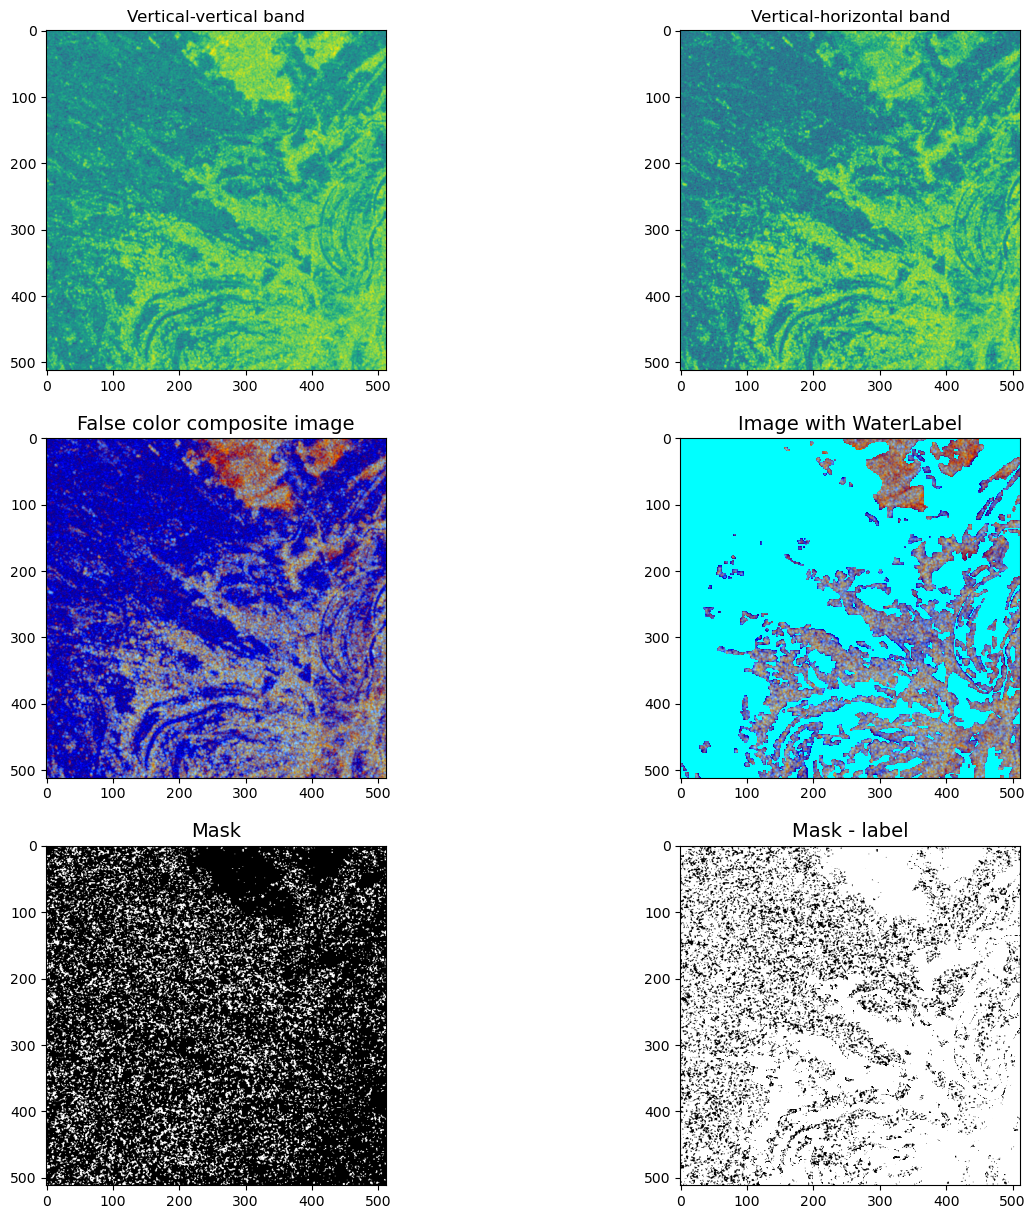

In [13]:
display_chip(25)

In [21]:
x1 = [[2,0],[4,5]]
x2 = [[3,1],[6,7]]
x = np.stack([x1,x2], axis=-1)
x

array([[[2, 3],
        [0, 1]],

       [[4, 6],
        [5, 7]]])

In [22]:
xt = np.transpose(x, [2, 0, 1])
xt

array([[[2, 0],
        [4, 5]],

       [[3, 1],
        [6, 7]]])

In [23]:
xe = np.expand_dims(xt, axis=0)
xe

array([[[[2, 0],
         [4, 5]],

        [[3, 1],
         [6, 7]]]])